# Hyperparameter Testing

Adjusting hyperparameters of the DL models on N170.

In [5]:
import DataLoader, Training, os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
df_path = os.getcwd()+"\\dataframes_hyperparameter\\"

In [6]:
import DataLoader
import torch
import sklearn
import os
import json
import numpy as np
import pandas as pd
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet, EEGNetv1, Deep4Net, TCN, EEGNetv4
from skorch.callbacks import LRScheduler
from skorch.dataset import CVSplit
from braindecode import EEGClassifier
from torch.utils.data import TensorDataset
from skorch.helper import predefined_split
from pathlib import Path
from sklearn.utils import class_weight

def init_model(parameters, valid_ds=None, class_weights=None):
    # TODO: Add more models.
    """
    Initializes the model and classifier depending on the parameters.
    """
    # choosing gpu if possible
    cuda = torch.cuda.is_available()
    device = 'cuda' if cuda else 'cpu'
    if cuda:
        torch.backends.cudnn.benchmark = True
    # set seed for reproducability
    set_random_seeds(seed=parameters["seed"], cuda=cuda)
    
    
    # load model
    if parameters["model"] == "eegnet":
        model = EEGNetv4(
            parameters["n_chans"],
            parameters["n_classes"],
            input_window_samples=parameters["input_window_samples"],
            final_conv_length="auto",
        )
    elif parameters["model"] == "shallow":
        model = ShallowFBCSPNet(
            parameters["n_chans"],
            parameters["n_classes"],
            input_window_samples=parameters["input_window_samples"],
            n_filters_time=40, 
            filter_time_length=25, 
            n_filters_spat=40, 
            pool_time_length=75, 
            pool_time_stride=15, 
            final_conv_length="auto"
            
        )
    elif parameters["model"] == "deep":
        model = Deep4Net(
            parameters["n_chans"],
            parameters["n_classes"],
            input_window_samples=parameters["input_window_samples"],
            n_filters_time=25, 
            n_filters_spat=25, 
            filter_time_length=10,
            # TODO: changed stride
            pool_time_length=2, 
            pool_time_stride=2, 
            n_filters_2=50, 
            filter_length_2=10, 
            n_filters_3=100, 
            filter_length_3=10, 
            n_filters_4=200, 
            filter_length_4=10,
            final_conv_length="auto",
        )
    elif parameters["model"] == "tcn":
        model = TCN(
            parameters["n_chans"],
            parameters["n_classes"],
            n_filters=50,
            n_blocks=7,
            kernel_size=2,
            drop_prob=0.3,
            add_log_softmax=True
        )
    
    # send model to gpu
    if cuda:
        model.cuda()
        
    if valid_ds==None:
        train_split=None
    else:
        train_split=predefined_split(valid_ds)
    
    # load classifier
    clf = EEGClassifier(
        model,
        criterion=torch.nn.NLLLoss,
        criterion__weight=class_weights,
        optimizer=torch.optim.AdamW,
        train_split=train_split,
        optimizer__lr=parameters["lr"],
        optimizer__weight_decay=parameters["weight_decay"],
        batch_size=parameters["batch_size"],
        callbacks=[
            "accuracy",
            "balanced_accuracy",
            #"roc_auc",
            ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=parameters["n_epochs"] - 1)),
        ],
        device=device,
    )
    clf.initialize()
    # number of trainable parameters
    #print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    return clf

def run_exp(data, labels, parameters):
    """
    Trains classifier using Stratified Cross Validation and saves parameters and history.
    """
    # path to save parameters to
    model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters[
        "model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
    Path(model_path).mkdir(parents=True, exist_ok=True)
    json.dump(parameters, open(model_path+"parameters.json", 'w' ))
    
    # calculate class weights
    class_weights=class_weight.compute_class_weight('balanced',np.unique(labels),labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    
    # create stratified splits
    cv = sklearn.model_selection.StratifiedShuffleSplit(parameters["n_splits"], test_size=0.2, random_state=42)
    cv_split = cv.split(data,labels)

    # train and validate on each split, then save parameters and history
    i = 0
    for train_idx, test_idx in cv_split:
        i += 1
        valid_ds = TensorDataset(torch.from_numpy(data[test_idx]), torch.from_numpy(labels[test_idx]))
        clf = init_model(parameters, valid_ds, class_weights)
        clf.fit(data[train_idx], y=labels[train_idx], epochs=parameters["n_epochs"])
        clf.save_params(f_params=model_path+"split_"+str(i)+"_lr"+str(parameters["lr"])+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(i)+"_lr"+str(parameters["lr"])+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(i)+"_lr"+str(parameters["lr"])+"_history.json")
        
def load_exp(parameters):
    """
    Loads the history json and puts it in a dataframe.
    """
    model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters[
        "model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
    df_list = []
    for i in range(1,parameters["n_splits"]+1):
        df_list.append(pd.read_json(model_path+"split_"+str(i)+"_lr"+str(parameters["lr"])+"_history.json"))
    df = pd.concat(df_list,axis=1)
    
    return df

# Optimize LR over all tasks

In [ ]:
parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "eegnet",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 255,
    "seed": 42,
    # classifier
    "lr": 0.005,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 25,
    "n_splits": 1,
    "model_folder": "models_hyperparameter_testing"
}
results = []
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    parameters["task"] = task
    df = DataLoader.load_df(parameters)
    data, labels = DataLoader.create_data_labels(df)
    for lr in [0.0025]:
        parameters["lr"] = lr
        run_exp(data, labels, parameters)
        results.append((task, lr, load_exp(parameters)["valid_balanced_accuracy"][parameters["n_epochs"]-1]))

In [110]:
df = pd.DataFrame(results, columns=["Task","LR","valid_balanced_accuracy"])
#df.to_csv(df_path+"eegnet_lr.csv",index=false)

In [29]:
df = pd.read_csv(df_path+"eegnet_lr.csv")
df

,Task,LR,valid_balanced_accuracy
0,N170,0.0100,0.771270
1,N170,0.0050,0.781546
2,N170,0.0025,0.763462
3,N400,0.0100,0.782147
4,N400,0.0050,0.792557
5,N400,0.0025,0.788599
6,P3,0.0100,0.791610
7,P3,0.0050,0.792636
8,P3,0.0025,0.780914
9,N2pc,0.0100,0.682419


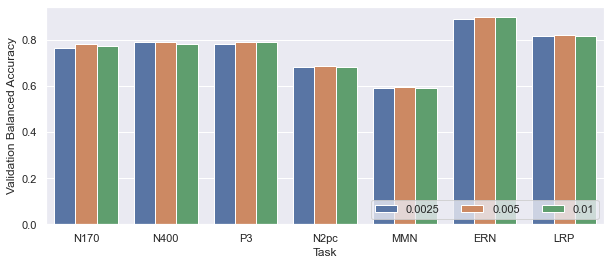

In [30]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 4))
fig = sns.barplot(x="Task", y="valid_balanced_accuracy", hue="LR", data=df)
plt.legend(loc='lower right', ncol=7)
fig.set(xlabel='Task', ylabel='Validation Balanced Accuracy');

## Shallow

In [ ]:
parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "shallow",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 255,
    "seed": 42,
    # classifier
    "lr": 0.005,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 25,
    "n_splits": 1,
    "model_folder": "models_hyperparameter_testing"
}
results = []
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    parameters["task"] = task
    df = DataLoader.load_df(parameters)
    data, labels = DataLoader.create_data_labels(df)
    for lr in [0.02, 0.01, 0.005]:
        parameters["lr"] = lr
        run_exp(data, labels, parameters)
        results.append((task, lr, load_exp(parameters)["valid_balanced_accuracy"][parameters["n_epochs"]-1]))

In [15]:
df = pd.DataFrame(results, columns=["Task","LR","valid_balanced_accuracy"])
#df.to_csv(df_path+"shallow_lr.csv",index=False)

In [23]:
df = pd.read_csv(df_path+"shallow_lr.csv")
df

,Task,LR,valid_balanced_accuracy
0,N170,0.020,0.728632
1,N170,0.010,0.737451
2,N170,0.005,0.752020
3,N400,0.020,0.768368
4,N400,0.010,0.781122
5,N400,0.005,0.780828
6,P3,0.020,0.763502
7,P3,0.010,0.779950
8,P3,0.005,0.760828
9,N2pc,0.020,0.675520


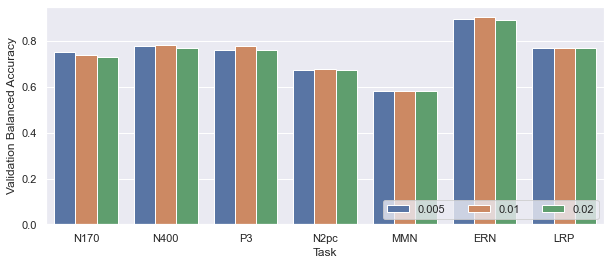

In [24]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 4))
fig = sns.barplot(x="Task", y="valid_balanced_accuracy", hue="LR", data=df)
plt.legend(loc='lower right', ncol=7)
fig.set(xlabel='Task', ylabel='Validation Balanced Accuracy');

# Deep

In [ ]:
parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "deep",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 255,
    "seed": 42,
    # classifier
    "lr": 0.005,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 25,
    "n_splits": 1,
    "model_folder": "models_hyperparameter_testing"
}
results = []
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    parameters["task"] = task
    df = DataLoader.load_df(parameters)
    data, labels = DataLoader.create_data_labels(df)
    for lr in [0.02, 0.01, 0.005]:
        parameters["lr"] = lr
        run_exp(data, labels, parameters)
        results.append((task, lr, load_exp(parameters)["valid_balanced_accuracy"][parameters["n_epochs"]-1]))

In [31]:
df = pd.DataFrame(results, columns=["Task","LR","valid_balanced_accuracy"])
df_path = os.getcwd()+"\\dataframes_hyperparameter\\"
#df.to_csv(df_path+"deep_lr.csv",index=False)

In [25]:
df = pd.read_csv(df_path+"deep_lr.csv")
df

,Task,LR,valid_balanced_accuracy
0,N170,0.020,0.793803
1,N170,0.010,0.799689
2,N170,0.005,0.804973
3,N400,0.020,0.761192
4,N400,0.010,0.781569
5,N400,0.005,0.773798
6,P3,0.020,0.764123
7,P3,0.010,0.788500
8,P3,0.005,0.793289
9,N2pc,0.020,0.689844


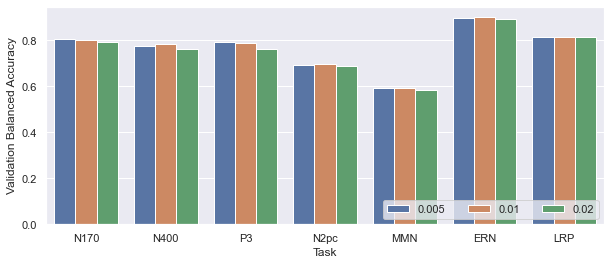

In [26]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 4))
fig = sns.barplot(x="Task", y="valid_balanced_accuracy", hue="LR", data=df)
plt.legend(loc='lower right', ncol=7)
fig.set(xlabel='Task', ylabel='Validation Balanced Accuracy');

In [20]:
parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "deep",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 255,
    "seed": 42,
    # classifier
    "lr": 0.005,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 25,
    "n_splits": 1,
    "model_folder": "models_hyperparameter_testing2"
}
results = []
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    parameters["task"] = task
    df = DataLoader.load_df(parameters)
    data, labels = DataLoader.create_data_labels(df)
    for lr in [0.1, 0.01, 0.001]:
        parameters["lr"] = lr
        run_exp(data, labels, parameters)
        results.append((task, lr, load_exp(parameters)["valid_balanced_accuracy"][parameters["n_epochs"]-1]))

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.5002                     0.5048        3.6891            0.4961                     0.5010        1.2178  0.1000  2.0918
      2            0.5601                     0.5612        0.7654            0.5618                     0.5631        0.6887  0.0996  0.7016
      3            0.5474                     0.5436        0.7129            0.5592                     0.5553        0.7633  0.0983  0.7271
      4            0.5800                     0.5828        0.7266            0.5748                     0.5780        0.6775  0.0962  0.6917
      5            0.5910                     0.5887      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.5074                     0.5047        1.1437            0.5108                     0.5080        0.8104  0.0100  0.7296
      2            0.6388                     0.6377        0.7643            0.6439                     0.6426        0.6926  0.0100  0.7360
      3            0.6497                     0.6497        0.7013            0.6517                     0.6518        0.6954  0.0098  0.7804
      4            0.6979                     0.6977        0.6415            0.6716                     0.6714        0.6073  0.0096  0.7679
      5            0.7256                     0.7249      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.6252                     0.6284        0.9099            0.6214                     0.6251        0.7476  0.0010  0.7494
      2            0.7240                     0.7245        0.7013            0.7156                     0.7162        0.5795  0.0010  0.7206
      3            0.7349                     0.7349        0.6238            0.7338                     0.7339        0.5627  0.0010  0.7306
      4            0.7489                     0.7500        0.6023            0.7364                     0.7376        0.5454  0.0010  0.7730
      5            0.7658                     0.7660      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.5570                     0.5462        4.2580            0.5530                     0.5432        1.7027  0.1000  0.5485
      2            0.5850                     0.6205        0.9027            0.5951                     0.6313        0.8165  0.0996  0.4089
      3            0.6547                     0.6567        0.6499            0.6415                     0.6418        0.8061  0.0983  0.4044
      4            0.6943                     0.6945        0.6953            0.7257                     0.7272        0.6096  0.0962  0.4035
      5            0.6511                     0.6724      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.6373                     0.6569        1.1510            0.6401                     0.6628        0.6652  0.0100  0.4059
      2            0.5890                     0.6174        0.8095            0.6183                     0.6489        1.0683  0.0100  0.4059
      3            0.6507                     0.6639        0.8586            0.6313                     0.6446        0.9677  0.0098  0.4059
      4            0.6456                     0.6177        0.7499            0.6401                     0.6126        0.6402  0.0096  0.4034
      5            0.7534                     0.7492      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.6601                     0.6780        0.8722            0.6647                     0.6850        0.6781  0.0010  0.4079
      2            0.7353                     0.7357        0.7488            0.7446                     0.7470        0.5213  0.0010  0.4209
      3            0.6692                     0.6885        0.6828            0.6444                     0.6650        0.7036  0.0010  0.4224
      4            0.7102                     0.7247        0.6400            0.7141                     0.7298        0.5432  0.0010  0.4129
      5            0.7411                     0.7405      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.7252                     0.6109        2.3562            0.7243                     0.6247        0.9464  0.1000  1.0307
      2            0.8279                     0.5181        0.8036            0.8239                     0.5114        0.8423  0.0996  0.9485
      3            0.7651                     0.6780        0.7143            0.7681                     0.6865        0.6234  0.0983  0.9405
      4            0.4192                     0.5834        0.7224            0.4233                     0.5907        0.6698  0.0962  0.9769
      5            0.8340                     0.5815      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.7553                     0.6538        1.1215            0.7468                     0.6531        0.7082  0.0100  0.9923
      2            0.8329                     0.5757        0.6806            0.8299                     0.5765        0.8551  0.0100  0.9565
      3            0.7923                     0.6719        0.6590            0.7814                     0.6712        0.6428  0.0098  0.9669
      4            0.7953                     0.7012        0.6384            0.7714                     0.6768        0.6651  0.0096  0.9629
      5            0.5906                     0.6683      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.7672                     0.6885        0.8982            0.7648                     0.6830        0.5778  0.0010  0.9884
      2            0.8184                     0.6511        0.6857            0.8047                     0.6283        0.6828  0.0010  0.9914
      3            0.7192                     0.6912        0.6236            0.7189                     0.7106        0.5841  0.0010  1.0078
      4            0.7835                     0.7266        0.6124            0.7748                     0.7212        0.5545  0.0010  1.0133
      5            0.7300                     0.6937      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.5145                     0.5122        2.1770            0.5005                     0.4980        0.7073  0.1000  1.5514
      2            0.5273                     0.5299        0.7240            0.5263                     0.5290        0.7081  0.0996  1.3319
      3            0.5194                     0.5159        0.6952            0.5162                     0.5125        0.8232  0.0983  1.2960
      4            0.5032                     0.5068        0.6946            0.5069                     0.5107        0.8115  0.0962  1.3250
      5            0.5708                     0.5682      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.5602                     0.5592        0.9732            0.5517                     0.5507        0.7649  0.0100  1.3484
      2            0.6385                     0.6390        0.7482            0.6311                     0.6318        0.6575  0.0100  1.3793
      3            0.6169                     0.6151        0.6645            0.6025                     0.6008        0.6864  0.0098  1.3753
      4            0.6603                     0.6598        0.6361            0.6537                     0.6532        0.6297  0.0096  1.3579
      5            0.6620                     0.6611      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.6293                     0.6280        0.9330            0.6030                     0.6014        0.6701  0.0010  1.2666
      2            0.6380                     0.6394        0.6934            0.6362                     0.6378        0.6502  0.0010  1.2876
      3            0.5800                     0.5773        0.6637            0.5739                     0.5711        0.6926  0.0010  1.2951
      4            0.6311                     0.6292        0.6451            0.6140                     0.6122        0.6542  0.0010  1.2656
      5            0.5860                     0.5833      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.7571                     0.5028        1.2409            0.7537                     0.4970        0.7119  0.1000  5.2699
      2            0.7782                     0.5004        1.1919            0.7777                     0.5009        1.6873  0.0996  4.7863
      3            0.2117                     0.5000        1.9243            0.2114                     0.4987        1.3302  0.0983  4.7588
      4            0.2071                     0.4998        2.1416            0.2077                     0.5008        1.1992  0.0962  4.9199
      5            0.7968                     0.5000      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.6009                     0.5730        0.9197            0.5968                     0.5617        0.6948  0.0100  5.0336
      2            0.6584                     0.5802        0.6942            0.6569                     0.5711        0.6782  0.0100  4.8630
      3            0.6696                     0.5716        0.6777            0.6666                     0.5594        0.6793  0.0098  4.7628
      4            0.5939                     0.5896        0.6748            0.5895                     0.5749        0.6761  0.0096  4.5509
      5            0.6826                     0.5869      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.5035                     0.5689        0.8174            0.5034                     0.5638        0.6868  0.0010  4.6777
      2            0.7458                     0.5370        0.7226            0.7430                     0.5302        0.7025  0.0010  4.6342
      3            0.6247                     0.5932        0.6962            0.6255                     0.5881        0.6732  0.0010  4.7459
      4            0.7170                     0.5586        0.6959            0.7114                     0.5473        0.6957  0.0010  4.7148
      5            0.7392                     0.5390      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.8779                     0.8471        1.8899            0.8673                     0.8281        0.4495  0.1000  2.2620
      2            0.8724                     0.8018        0.4648            0.8660                     0.7903        0.4621  0.0996  2.0495
      3            0.8924                     0.8430        0.4494            0.8879                     0.8289        0.4384  0.0983  1.9957
      4            0.9050                     0.8285        0.5872            0.8984                     0.8110        0.5151  0.0962  2.0655
      5            0.8602                     0.8624      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.9117                     0.7844        0.6727            0.9093                     0.7728        0.6099  0.0100  2.0894
      2            0.8846                     0.8236        0.4404            0.8776                     0.8028        0.4411  0.0100  2.1004
      3            0.8944                     0.8799        0.3422            0.8894                     0.8622        0.3602  0.0098  2.1079
      4            0.8545                     0.8802        0.3327            0.8424                     0.8548        0.3533  0.0096  2.0615
      5            0.9004                     0.8919      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.8457                     0.8512        0.5765            0.8355                     0.8282        0.4317  0.0010  1.9583
      2            0.8843                     0.8283        0.3920            0.8769                     0.8036        0.4397  0.0010  1.9483
      3            0.8702                     0.8803        0.3495            0.8648                     0.8591        0.3542  0.0010  2.0062
      4            0.8913                     0.8826        0.3390            0.8804                     0.8571        0.3452  0.0010  1.9852
      5            0.8811                     0.8819      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 1 0 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.5907                     0.5905        1.7826            0.5960                     0.5956        0.6775  0.1000  2.2181
      2            0.7485                     0.7480        0.6205            0.7424                     0.7419        0.5187  0.0996  1.9777
      3            0.7418                     0.7409        0.5924            0.7364                     0.7355        0.5826  0.0983  1.9787
      4            0.7561                     0.7571        0.5771            0.7452                     0.7463        0.5237  0.0962  2.2346
      5            0.6252                     0.6223      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 1 0 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.7527                     0.7527        0.8888            0.7396                     0.7396        0.5259  0.0100  1.9777
      2            0.7743                     0.7739        0.5466            0.7654                     0.7650        0.4898  0.0100  2.2051
      3            0.7904                     0.7899        0.4922            0.7773                     0.7767        0.4708  0.0098  2.2620
      4            0.7929                     0.7931        0.4729            0.7888                     0.7891        0.4630  0.0096  2.2840
      5            0.8032                     0.8031      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 1 0 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.7477                     0.7467        0.7537            0.7290                     0.7279        0.5458  0.0010  2.2575
      2            0.7895                     0.7897        0.5326            0.7698                     0.7701        0.4738  0.0010  2.2435
      3            0.7839                     0.7838        0.4991            0.7769                     0.7768        0.4790  0.0010  2.2386
      4            0.7394                     0.7412        0.4792            0.7274                     0.7293        0.5464  0.0010  2.0959
      5            0.7944                     0.7944      

In [27]:
df = pd.DataFrame(results, columns=["Task","LR","valid_balanced_accuracy"])


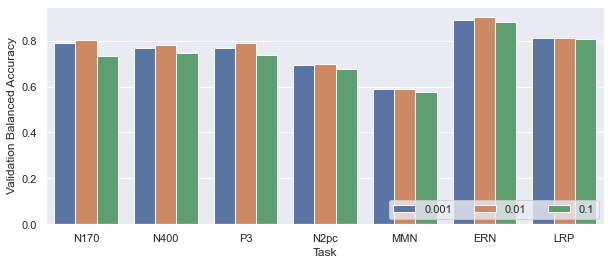

In [28]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 4))
fig = sns.barplot(x="Task", y="valid_balanced_accuracy", hue="LR", data=df)
plt.legend(loc='lower right', ncol=7)
fig.set(xlabel='Task', ylabel='Validation Balanced Accuracy');

# TCN

In [85]:
import DataLoader
import torch
import sklearn
import os
import json
import numpy as np
import pandas as pd
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet, EEGNetv1, Deep4Net, TCN, EEGNetv4
from skorch.callbacks import LRScheduler
from skorch.dataset import CVSplit
from braindecode import EEGClassifier
from torch.utils.data import TensorDataset
from skorch.helper import predefined_split
from pathlib import Path
from sklearn.utils import class_weight

def init_model(parameters, valid_ds=None, class_weights=None):
    # TODO: Add more models.
    """
    Initializes the model and classifier depending on the parameters.
    """
    # choosing gpu if possible
    cuda = torch.cuda.is_available()
    device = 'cuda' if cuda else 'cpu'
    if cuda:
        torch.backends.cudnn.benchmark = True
    # set seed for reproducability
    set_random_seeds(seed=parameters["seed"], cuda=cuda)
    
    
    # load model
    if parameters["model"] == "eegnet":
        model = EEGNetv4(
            parameters["n_chans"],
            parameters["n_classes"],
            input_window_samples=parameters["input_window_samples"],
            final_conv_length="auto",
        )
    elif parameters["model"] == "shallow":
        model = ShallowFBCSPNet(
            parameters["n_chans"],
            parameters["n_classes"],
            input_window_samples=parameters["input_window_samples"],
            n_filters_time=40, 
            filter_time_length=25, 
            n_filters_spat=40, 
            pool_time_length=75, 
            pool_time_stride=15, 
            final_conv_length="auto"
            
        )
    elif parameters["model"] == "deep":
        model = Deep4Net(
            parameters["n_chans"],
            parameters["n_classes"],
            input_window_samples=parameters["input_window_samples"],
            n_filters_time=25, 
            n_filters_spat=25, 
            filter_time_length=10,
            # TODO: changed stride
            pool_time_length=2, 
            pool_time_stride=2, 
            n_filters_2=50, 
            filter_length_2=10, 
            n_filters_3=100, 
            filter_length_3=10, 
            n_filters_4=200, 
            filter_length_4=10,
            final_conv_length="auto",
        )
    elif parameters["model"] == "tcn":
        model = TCN(
            parameters["n_chans"],
            parameters["n_classes"],
            n_filters=15,
            n_blocks=6,
            kernel_size=3,
            drop_prob=0.1,
            add_log_softmax=True
        )
    
    # send model to gpu
    if cuda:
        model.cuda()
        
    if valid_ds==None:
        train_split=None
    else:
        train_split=predefined_split(valid_ds)
    
    # load classifier
    clf = EEGClassifier(
        model,
        criterion=torch.nn.NLLLoss,
        criterion__weight=class_weights,
        optimizer=torch.optim.AdamW,
        train_split=train_split,
        optimizer__lr=parameters["lr"],
        optimizer__weight_decay=parameters["weight_decay"],
        batch_size=parameters["batch_size"],
        callbacks=[
            "accuracy",
            "balanced_accuracy",
            #"roc_auc",
            ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=parameters["n_epochs"] - 1)),
        ],
        device=device,
    )
    clf.initialize()
    # number of trainable parameters
    #print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    return clf

In [87]:
parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "tcn",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 255,
    "seed": 42,
    # classifier
    "lr": 0.005,
    "weight_decay": 0.0,
    "batch_size": 64,
    "n_epochs": 25,
    "n_splits": 1,
    "model_folder": "models_hyperparameter_testing"
}
results = []
for task in ["N170"]:
    parameters["task"] = task
    df = DataLoader.load_df(parameters)
    data, labels = DataLoader.create_data_labels(df)
    for lr in [0.01,0.005,0.001]:
        parameters["lr"] = lr
        run_exp(data[:,:,:253], labels, parameters)
        results.append((task, lr, load_exp(parameters)["valid_balanced_accuracy"][parameters["n_epochs"]-1]))

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.5502                     0.5498        0.8006            0.5169                     0.5163        0.6999  0.0100  1.0352
      2            0.5703                     0.5694        0.6955            0.5125                     0.5117        0.6986  0.0100  0.9993
      3            0.5724                     0.5717        0.6936            0.5272                     0.5265        0.7029  0.0098  0.9973
      4            0.5203                     0.5235        0.7001            0.4814                     0.4851        0.6985  0.0096  0.9953
      5            0.5584                     0.5564      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.5588                     0.5586        0.7658            0.5117                     0.5116        0.7037  0.0050  1.0602
      2            0.5521                     0.5515        0.6978            0.5367                     0.5361        0.6964  0.0050  1.0073
      3            0.5947                     0.5950        0.6879            0.5506                     0.5510        0.6914  0.0049  1.0193
      4            0.5910                     0.5908        0.6849            0.5618                     0.5614        0.6869  0.0048  1.0013
      5            0.6378                     0.6366      

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.5301                     0.5291        0.7809            0.5004                     0.4992        0.7117  0.0010  1.0312
      2            0.5541                     0.5539        0.7075            0.5350                     0.5347        0.6982  0.0010  1.0382
      3            0.5724                     0.5731        0.6958            0.5272                     0.5280        0.6991  0.0010  1.0053
      4            0.5757                     0.5776        0.6876            0.5056                     0.5078        0.7013  0.0010  1.0422
      5            0.6049                     0.6042      

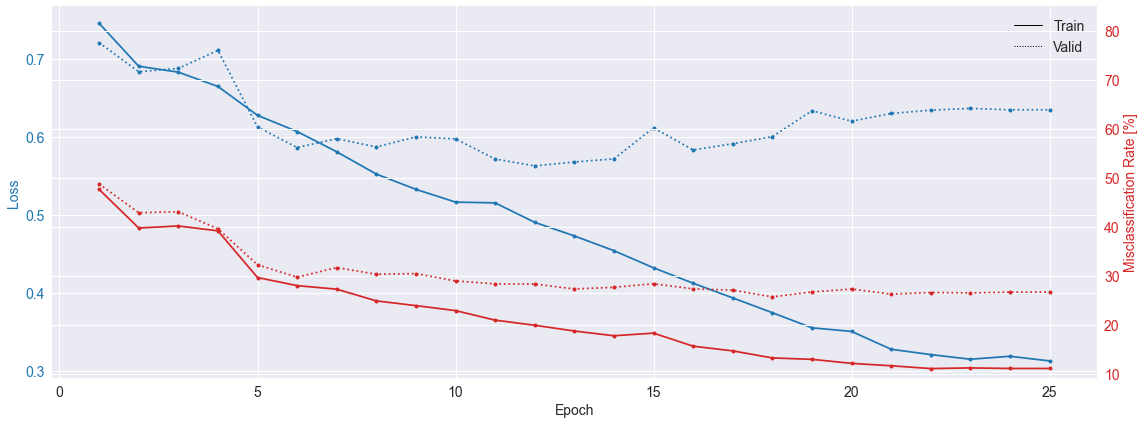

In [61]:
## modified from braindecode
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

## load history
clf = init_model(parameters)
model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters["model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_lr"+str(parameters["lr"])+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_lr"+str(parameters["lr"])+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_lr"+str(parameters["lr"])+"_history.json")

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_balanced_accuracy', 'valid_balanced_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_balanced_accuracy,
               valid_misclass=100 - 100 * df.valid_balanced_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(16, 6))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14, ms=4)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False, ms=4)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

In [5]:
df = DataLoader.load_df(parameters)
data, labels = DataLoader.create_data_labels(df)

In [133]:
parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    # model
    "model": "eegnet",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 255,
    "seed": 42,
    # classifier
    "lr": 0.005,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 25,
    "n_splits": 1,
    "model_folder": "models_hyperparameter_testing"
}
df = DataLoader.load_df(parameters)
data, labels = DataLoader.create_data_labels(df)

In [134]:
df["subjectID"].value_counts()

1     158
16    157
13    157
32    157
18    157
6     156
25    156
4     156
8     155
31    154
20    154
2     153
35    153
3     149
12    149
30    148
29    148
37    148
19    147
10    147
23    147
21    147
24    147
7     147
33    146
36    146
14    145
11    144
27    143
39    142
38    140
22    140
17    139
28    139
26    135
9     134
5     127
34    122
0     113
15     79
Name: subjectID, dtype: int64

# EEGNET

In [86]:
parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "eegnet",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 255,
    "seed": 42,
    # classifier
    "lr": 0.005,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 25,
    "n_splits": 1,
    "model_folder": "models_hyperparameter_testing"
}
df = DataLoader.load_df(parameters)
data, labels = DataLoader.create_data_labels(df)
run_exp(data, labels, parameters)

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.6462                     0.6458        0.7023            0.6465                     0.6461        0.6488  0.0050  1.9294
      2            0.6938                     0.6937        0.6209            0.6793                     0.6792        0.5969  0.0050  1.7030
      3            0.7321                     0.7324        0.5938            0.7079                     0.7084        0.5736  0.0049  1.6960
      4            0.7457                     0.7454        0.5637            0.7303                     0.7302        0.5472  0.0048  1.8182
      5            0.7154                     0.7174      

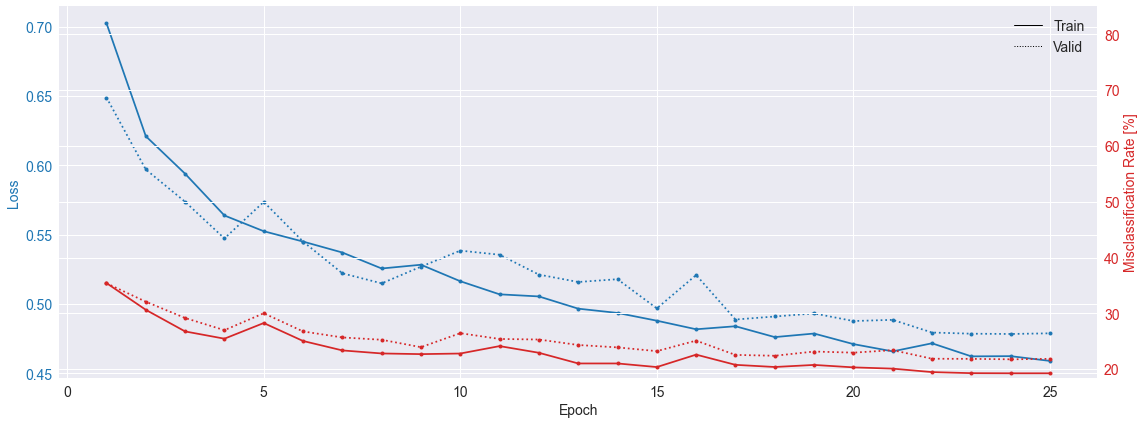

In [88]:
## modified from braindecode
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

## load history
clf = init_model(parameters)
model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters["model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_history.json")

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_balanced_accuracy', 'valid_balanced_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_balanced_accuracy,
               valid_misclass=100 - 100 * df.valid_balanced_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(16, 6))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14, ms=4)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False, ms=4)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

# Shallow

In [70]:
parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "shallow",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 255,
    "seed": 42,
    # classifier
    "lr": 0.000625,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 25,
    "n_splits": 1,
    "model_folder": "models_hyperparameter_testing"
}
df = DataLoader.load_df(parameters)
data, labels = DataLoader.create_data_labels(df)
run_exp(data, labels, parameters)

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.6127                     0.6127        1.1104            0.6067                     0.6065        0.6672  0.0006  0.8540
      2            0.6183                     0.6174        0.8768            0.6240                     0.6233        0.6465  0.0006  0.8172
      3            0.6823                     0.6821        0.8179            0.6491                     0.6488        0.6275  0.0006  0.7882
      4            0.6888                     0.6891        0.7503            0.6413                     0.6414        0.6311  0.0006  0.8836
      5            0.7031                     0.7040      

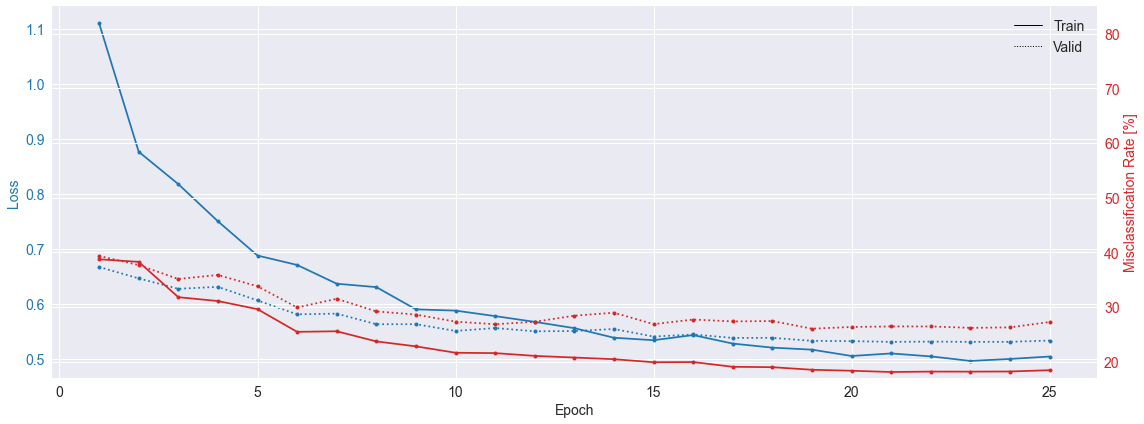

In [71]:
## modified from braindecode
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

## load history
clf = init_model(parameters)
model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters["model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_history.json")

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_balanced_accuracy', 'valid_balanced_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_balanced_accuracy,
               valid_misclass=100 - 100 * df.valid_balanced_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(16, 6))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14, ms=4)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False, ms=4)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

# Deep

In [78]:
parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "deep",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 255,
    "seed": 42,
    # classifier
    "lr": 0.01,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 25,
    "n_splits": 1,
    "model_folder": "models_hyperparameter_testing"
}
df = DataLoader.load_df(parameters)
data, labels = DataLoader.create_data_labels(df)
run_exp(data, labels, parameters)

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss      lr     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ------  ------
      1            0.5041                     0.5013        1.1441            0.5099                     0.5069        0.8231  0.0100  0.9194
      2            0.6440                     0.6426        0.7741            0.6543                     0.6527        0.6690  0.0100  0.7016
      3            0.6481                     0.6485        0.6999            0.6577                     0.6581        0.6892  0.0098  0.7036
      4            0.6548                     0.6543        0.6496            0.6404                     0.6399        0.6759  0.0096  0.6971
      5            0.7156                     0.7144      

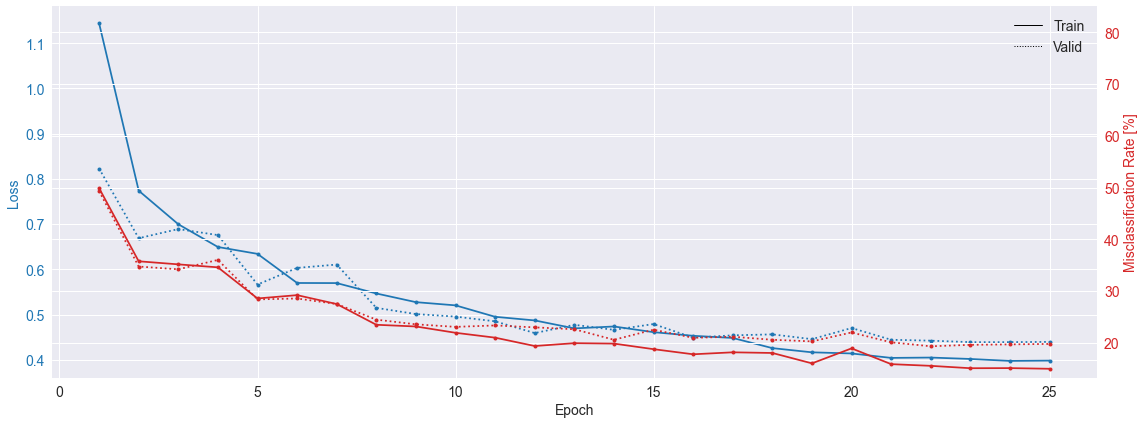

In [79]:
## modified from braindecode
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

## load history
clf = init_model(parameters)
model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters["model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_history.json")

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_balanced_accuracy', 'valid_balanced_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_balanced_accuracy,
               valid_misclass=100 - 100 * df.valid_balanced_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(16, 6))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14, ms=4)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False, ms=4)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()